In [6]:
# Importació de llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
import plotly.io as pio

# Preprocessament
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Carrega el dataset
df = pd.read_csv('Conjunt de dades Preprocessades/Datasets/Merged_Stock_Dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])

features = ["Open","High","Low","Close","Volume",
            "EMA_7","EMA_40","MACD","Signal_Line",
            "MACD_Hist","RSI","ATR"]

target_column = 'Close'
sequence_length = 30  

X_all, y_all = [], []

# Guardarar també a quin asset pertany cada seqüència 
assets_all = []

# Per guardar escaladors
scalers = {}

for asset in df['Asset'].unique():
    asset_df = df[df['Asset'] == asset].sort_values('Date')

    # Normalitzar les features per asset
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(asset_df[features])
    scalers[asset] = scaler

    asset_df_scaled = pd.DataFrame(scaled_features, columns=features)
    asset_df_scaled['Date'] = asset_df['Date'].values
    asset_df_scaled['Asset'] = asset_df['Asset'].values

    # Crear seqüències
    for i in range(sequence_length, len(asset_df_scaled) - 1):
        seq_x = asset_df_scaled[features].iloc[i-sequence_length:i].values
        seq_y = asset_df_scaled[target_column].iloc[i+1]
        X_all.append(seq_x)
        y_all.append(seq_y)
        assets_all.append(asset)

X_all = np.array(X_all)
y_all = np.array(y_all)
assets_all = np.array(assets_all)

print(f'Total samples: {X_all.shape[0]}')


# Separació train / val / test temporal per asset

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for asset in np.unique(assets_all):
    idxs = np.where(assets_all == asset)[0]

    n = len(idxs)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    X_train.append(X_all[idxs[:train_end]])
    y_train.append(y_all[idxs[:train_end]])

    X_val.append(X_all[idxs[train_end:val_end]])
    y_val.append(y_all[idxs[train_end:val_end]])

    X_test.append(X_all[idxs[val_end:]])
    y_test.append(y_all[idxs[val_end:]])

# Concatenar per tenir arrays complets
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(f'Train samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')


Total samples: 10038
Train samples: 7021
Validation samples: 1504
Test samples: 1513


In [8]:
# LSTM Model
SEQ_LENGTH=30


def build_regularized_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.001):
    """
    Model LSTM amb regularització L2 i més Dropout per evitar sobreentrenament
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        LSTM(lstm_units // 2, kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Inicialitzar LSTM model
lstm_model = build_regularized_lstm_model((SEQ_LENGTH, X_train.shape[2]))

lstm_model.summary()

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 192 (768.00 B)

In [9]:
# Reentrenar amb model nou
lstm_model = build_regularized_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_regularized_lstm_model.keras', save_best_only=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,  # pots pujar si vols
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.4137 - mae: 0.3851 - val_loss: 0.2515 - val_mae: 0.3234
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1532 - mae: 0.1436 - val_loss: 0.1246 - val_mae: 0.1167
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1177 - mae: 0.1030 - val_loss: 0.0956 - val_mae: 0.0757
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0925 - mae: 0.0807 - val_loss: 0.0793 - val_mae: 0.0771
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0751 - mae: 0.0750 - val_loss: 0.0709 - val_mae: 0.1085
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0603 - mae: 0.0683 - val_loss: 0.0563 - val_mae: 0.0905
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0482 - mae: 0.0608 - val_loss: 0.0415 - val_mae: 0.0618
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0387 - mae: 0.0541 - val_loss: 0.0369 - val_mae: 0.0797
Epoch 9/100
220/220 ━━━━━━━━━━━━━━━━━━━━

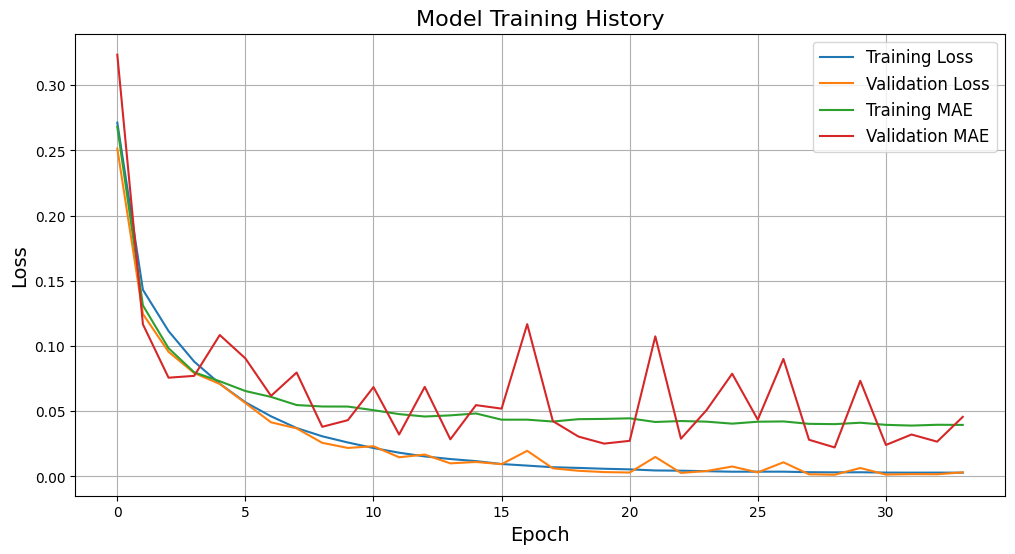

In [10]:
# Representació gràfica de l'historial d'entrenament
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    
    plt.title('Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [11]:
# Prediccions LSTM sobre train i càlcul de residus
y_pred_lstm_train = lstm_model.predict(X_train).flatten()
residuals_train = y_train - y_pred_lstm_train

# Preparar dades per a XGBoost (reshape 3D -> 2D)
xgb_X_train = X_train.reshape(X_train.shape[0], -1)

# Entrenar XGBoost per predir residus
xgb_residual_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_residual_model.fit(xgb_X_train, residuals_train)

# Prediccions híbrides sobre dades de test
# Predicció LSTM
y_pred_lstm_test = lstm_model.predict(X_test).flatten()

# Preparar dades test per XGBoost
xgb_X_test = X_test.reshape(X_test.shape[0], -1)

# Predicció residus amb XGBoost
residuals_pred_test = xgb_residual_model.predict(xgb_X_test)

# Predicció final suma LSTM + residus XGBoost
y_pred_hybrid = y_pred_lstm_test + residuals_pred_test

# Avaluar el model híbrid
mse = mean_squared_error(y_test, y_pred_hybrid)
mae = mean_absolute_error(y_test, y_pred_hybrid)

print(f"Model híbrid LSTM + XGBoost — MSE: {mse:.5f}, MAE: {mae:.5f}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model híbrid LSTM + XGBoost — MSE: 0.00163, MAE: 0.03161


In [12]:
# Funció per avaluar models amb diverses mètriques
def evaluate_models(y_true, y_pred_lstm_test, y_pred_hybrid):

    results = []
    
    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }
    
    results.append(calculate_metrics(y_true, y_pred_lstm_test, "LSTM"))
    results.append(calculate_metrics(y_true, y_pred_hybrid, "Hybrid"))
    
    return pd.DataFrame(results)

results_df = evaluate_models(y_test, y_pred_lstm_test, y_pred_hybrid)

print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,MSE,MAE,R² Score
0,LSTM,0.001245,0.028193,0.9708
1,Hybrid,0.001626,0.031606,0.9618


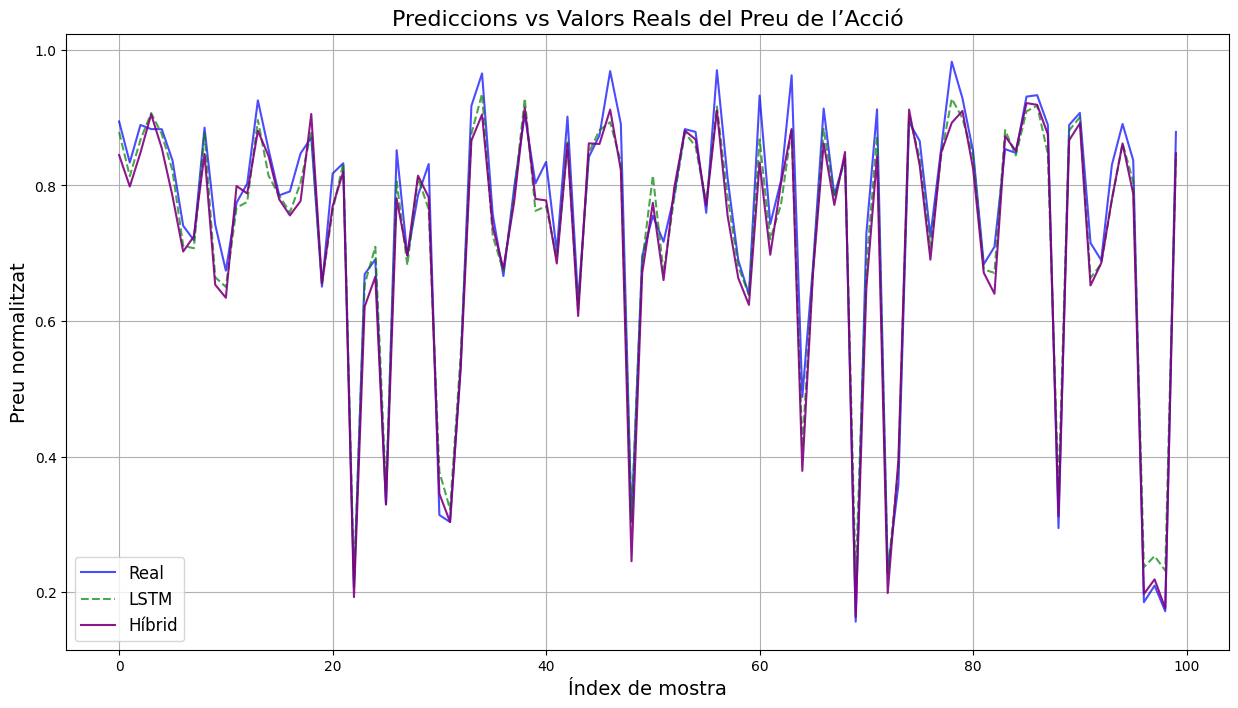

In [14]:
def plot_predictions(y_true, y_pred_lstm_test, y_pred_hybrid, n_samples=100):
    
    plt.figure(figsize=(15, 8))
    
    # Selecciona un subconjunt per visualitzar més clarament
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)
    
    plt.plot(y_true[idx], label='Real', color='blue', alpha=0.7)
    plt.plot(y_pred_lstm_test[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(y_pred_hybrid[idx], label='Híbrid', color='purple', linestyle='-', alpha=0.9)
    
    plt.title('Prediccions vs Valors Reals del Preu de l’Acció', fontsize=16)
    plt.xlabel('Índex de mostra', fontsize=14)
    plt.ylabel('Preu normalitzat', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_predictions(y_test, y_pred_lstm_test, y_pred_hybrid)


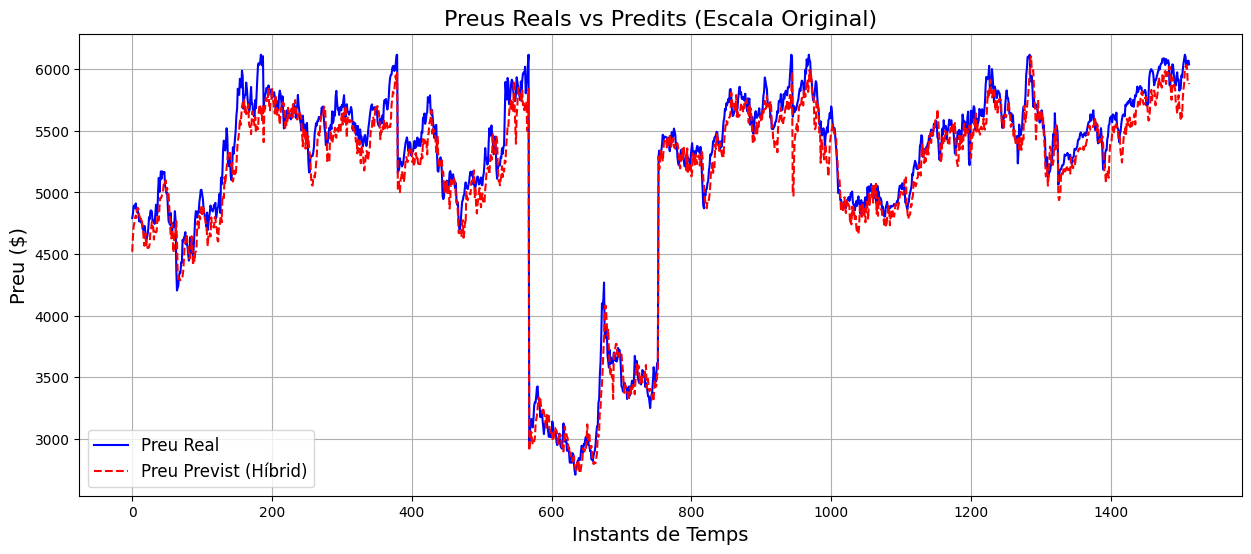

In [13]:
def inverse_transform_predictions(preds, scaler):
    # Reshape per fer la transformació inversa
    preds_2d = preds.reshape(-1, 1)
    dummy = np.zeros((len(preds_2d), len(scaler.feature_names_in_)))
    
    # Posar les prediccions a la columna 'Close'
    close_idx = list(scaler.feature_names_in_).index('Close')
    dummy[:, close_idx] = preds_2d.flatten()
    
    # Fer la transformació inversa
    original_scale = scaler.inverse_transform(dummy)[:, close_idx]
    
    return original_scale

# Obtenir preus reals i preus predits en escala original
actual_prices = inverse_transform_predictions(y_test, scaler)
hybrid_prices = inverse_transform_predictions(y_pred_hybrid, scaler)

# Representar gràficament
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Preu Real', color='blue')
plt.plot(hybrid_prices, label='Preu Previst (Híbrid)', color='red', linestyle='--')
plt.title('Preus Reals vs Predits (Escala Original)', fontsize=16)
plt.xlabel('Instants de Temps', fontsize=14)
plt.ylabel('Preu ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
#Forward forecasting
import numpy as np
import pandas as pd
test_asset_indices = []

for asset in np.unique(assets_all):
    idxs = np.where(assets_all == asset)[0]
    n = len(idxs)
    train_end = int(n * 0.7)
    val_end = train_end + int(n * 0.15)
    test_idxs = idxs[val_end:]
    test_asset_indices.extend(test_idxs)

test_asset_indices = np.array(test_asset_indices)

# Paràmetres
future_days = 10
sequence_length = X_test.shape[1]  

# Agafar l'última seqüència per asset de X_test
from collections import defaultdict

# Organitzar les últimes seqüències de test per asset
last_sequences = defaultdict(list)
for i, asset in enumerate(assets_all[test_asset_indices]):
    last_sequences[asset].append(X_test[i])

# Agafar només l'última seqüència per asset
for asset in last_sequences:
    last_sequences[asset] = last_sequences[asset][-1]

# Funció per desnormalitzar 
def desnormalize(pred_scaled, scaler, feature_idx):
    dummy = np.zeros((1, len(features)))
    dummy[0, feature_idx] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[0, feature_idx]

# Guardarar totes les prediccions futures
future_predictions = []

for asset, seq in last_sequences.items():
    scaler = scalers[asset]
    feature_idx = features.index('Close')
    sequence = seq.copy()
    
    preds_scaled = []
    future_dates = []
    # Última data real d'aquest asset
    last_date = df[df['Asset'] == asset]['Date'].max()

    for i in range(future_days):
        # Predicció LSTM
        pred_lstm = lstm_model.predict(sequence.reshape(1, sequence.shape[0], sequence.shape[1])).flatten()[0]

        # Predicció residu XGBoost 
        xgb_input = sequence.reshape(1, -1)
        pred_residual = xgb_residual_model.predict(xgb_input)[0]

        pred_final_scaled = pred_lstm + pred_residual  # si no tens xgb, posa només pred_lstm
        preds_scaled.append(pred_final_scaled)

        # Actualitzar la seqüència: fer scroll per posar la nova predicció al feature 'Close'
        new_step = sequence[-1].copy()
        new_step[feature_idx] = pred_final_scaled
        sequence = np.vstack([sequence[1:], new_step])

        # Data següent
        next_date = pd.to_datetime(last_date) + pd.Timedelta(days=i + 1)
        future_dates.append(next_date.strftime('%Y-%m-%d'))

    # Desnormalitzar totes les prediccions
    preds_original = [desnormalize(p, scaler, feature_idx) for p in preds_scaled]

    # Guardar en dataframe
    df_pred = pd.DataFrame({
        'Asset': asset,
        'Date': future_dates,
        'Predicted_Close': preds_original
    })
    future_predictions.append(df_pred)

# Concatenar tots els assets
future_predictions_df = pd.concat(future_predictions, ignore_index=True)

future_predictions_df.to_csv('Future_Predictions_All_Assets.csv', index=False)
print("Prediccions futures desades a 'Future_Predictions_All_Assets.csv'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━